# Synchronize sensor data

In [2]:
import logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(asctime)s: %(message)s')

import os
import json
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.signal as sig

### Set all the parameters

In [3]:
patient = 'P101'
#session = 'S002'
session = 'S003'
input_data_root = 'data_public'
output_data_root = 'data_private'
output_file = 'all_sensors.csv'

### Read external signals

In [4]:
def get_video_filename():
    """

    :return:
    """
    data_dict = json.loads(raw_json)
    video_filename = data_dict["videos"]["phone"]["files"][0]
    return video_filename
def get_filename(in_filename, file_type):
    """

    :param in_filename:
    :param file_type:
    :return:
    """
    for fname in os.listdir(raw_data_dir):
        if in_filename in fname and file_type in fname:
            return str(fname)

def get_rawdata_json():
    """

    :return:
    """
    name = raw_data_dir

    metis = {"events": get_filename("events", "csv"),
             "sensors": get_filename("sensors", "csv")}
    sensors ={"OH1":
                  {"ACC":{"dir":"",
                          "files":[get_filename("ACC", "txt")]},
                   "PPG":{"dir":"",
                          "files":[get_filename("PPG", "txt")]}},
              "H10":
                  {"ECG":{"dir":"",
                          "files":[get_filename("ECG", "txt")]},
                   "ACC":{"dir":"",
                          "files":[get_filename("ACC", "txt")]}}}
    videos = {"phone":
                  {"dir":"phone",
                   "files":[get_filename("P", "mp4")]},
              "face":
                  {"dir":"phone",
                   "files":""},
              "body":
                  {"dir":"phone",
                   "files":""},
              "face_gopro":
                  {"dir":"phone",
                   "files":""}}

    data = {"name":name,
            "metis":metis,
            "sensors":sensors,
            "videos":videos}

    raw_json = json.dumps(data, indent=4)
    with open("data_file.json", "w") as write_file:
        json.dump(data, write_file, indent=4)
    return raw_json


In [5]:
def get_polar_sensor(sensor_file, sensor_cols=None):
    """

    :param sensor_file:
    :param sensor_cols:
    :return:
    """
    if sensor_cols is None:
        df = pd.read_csv(sensor_file, delimiter=";")
    else:
        df = pd.read_csv(sensor_file, delimiter=";", names=sensor_cols,
                         skiprows=1)
    df['timestamp'] = pd.to_datetime(df['Phone timestamp'], unit='ns').dt.round('1ms')
    #df['timestamp'] = df['timestamp'] + pd.DateOffset(years=30, days=-1)
    df = df.set_index("timestamp")
    return df


logging.info("Obtaining collected data ...")
#raw_data_dir = "..\\dataset\\good_sync\\perry-movement-3"
raw_data_dir = "/home/eyalgolan/PycharmProjects/KOIOS/first_video/"
raw_json = get_rawdata_json()
data_dict = json.loads(raw_json)
n_sensors = len(data_dict["sensors"])

logging.info(f'Total number of sensors: {n_sensors}')
files, df = {}, {}
for sname, sdata in data_dict['sensors'].items():
    for dname, ddata in sdata.items():
        sensor = (sname, dname)
        files[sensor] = os.path.join(raw_data_dir, ddata['dir'], ddata['files'][0])
        logging.info(f'Sensor: {sname} Data: {dname} File: {files[sensor]}')
        df[sensor] = get_polar_sensor(files[sensor])

INFO: 2021-04-30 23:52:55,859: Obtaining collected data ...
INFO: 2021-04-30 23:52:55,866: Total number of sensors: 2
INFO: 2021-04-30 23:52:55,867: Sensor: OH1 Data: ACC File: /home/eyalgolan/PycharmProjects/KOIOS/first_video/Polar_OH1_6A32F923_20210427_112816_ACC.txt
INFO: 2021-04-30 23:52:56,052: Sensor: OH1 Data: PPG File: /home/eyalgolan/PycharmProjects/KOIOS/first_video/Polar_OH1_6A32F923_20210427_112816_PPG.txt
INFO: 2021-04-30 23:52:56,128: Sensor: H10 Data: ECG File: /home/eyalgolan/PycharmProjects/KOIOS/first_video/Polar_H10_5D42182B_20210427_112816_ECG.txt
INFO: 2021-04-30 23:52:56,178: Sensor: H10 Data: ACC File: /home/eyalgolan/PycharmProjects/KOIOS/first_video/Polar_OH1_6A32F923_20210427_112816_ACC.txt


### Plot external signals

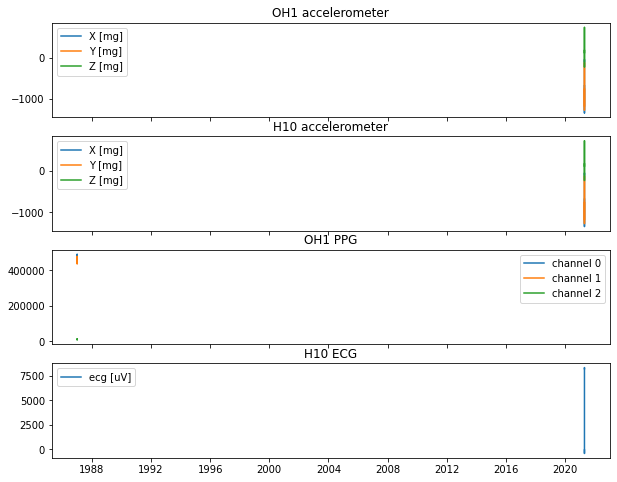

In [6]:
def plot_acc(df, key, fields, ax, title=''):
    if key is None:
        cdf = df
    else:
        if key in df:
            cdf = df[key]
        else: 
            logging.info(f'Key ({key}) does not exist')
            return
    for field in fields:
        ax.plot(cdf.index, cdf[field], label=field)
    ax.legend()
    ax.set_title(title)

if n_sensors > 0:
    fig, ax = plt.subplots(figsize=(10,8), nrows=4, ncols=1, sharex=True)
    plot_acc(df,('OH1','ACC'), ['X [mg]', 'Y [mg]', 'Z [mg]'], ax[0],'OH1 accelerometer')
    plot_acc(df,('H10','ACC'), ['X [mg]', 'Y [mg]', 'Z [mg]'], ax[1], 'H10 accelerometer')
    plot_acc(df,('OH1','PPG'), ['channel 0', 'channel 1', 'channel 2'], ax[2], 'OH1 PPG')
    plot_acc(df,('H10','ECG'), ['ecg [uV]'], ax[3], 'H10 ECG')

### Read phone sensors

In [103]:
sensor_cols = ["Time", "Junk1", "Sensor", "X", "Y", "Z", "UX", "UY", "UZ", "Junk2" ]
data_dict = json.loads(raw_json)
sensor_files = data_dict['metis']['sensors']

if isinstance(sensor_files, list):
    frames = []
    for i,f in enumerate(sensor_files):
        frames.append(pd.read_csv(os.path.join(raw_data_dir,f), skiprows=1, names=sensor_cols, engine="python", usecols=[i for i in range(10)]))
        sdf = pd.concat(frames, ignore_index = True)
else:
    sdf = pd.read_csv(os.path.join(raw_data_dir, sensor_files), skiprows=1, names=sensor_cols, engine="python", usecols=[i for i in range(10)])

sdf['DT'] = pd.to_datetime(sdf.Time, errors='coerce', format='%Y-%m-%d_%H:%M:%S:%f')
#sdf['DT'] = pd.to_datetime(sdf.Time, errors='coerce', format='%Y-%m-%d %H:%M:%S:%f')
sdf = sdf.drop(labels=["Junk1", "Junk2","Time"], axis=1)
sdf = sdf.drop(labels=["UX", "UY","UZ"], axis=1)
sdf['Sensor'] = sdf['Sensor'].astype('category')
sdf = sdf.dropna()
#display(sdf.head(5))
sdf

,Sensor,X,Y,Z,DT


In [101]:
def clean_sensor(sensor_df, idx):
    logging.info(f'Original number of samples: {sensor_df.shape[0]}')
    # Leave unique values per sample
    sensor_df = sensor_df.groupby('DT').mean()
    logging.info(f'After duplicate removal, number of samples: {sensor_df.shape[0]}')
    # Add missing data
    cidx = idx.union(sensor_df.index)
    sensor_df = sensor_df.reindex(cidx).interpolate(method='linear')
    sensor_df = sensor_df.loc[idx]
    logging.info(f'After interpolation to 100 samples/sec, number of samples: {sensor_df.shape[0]}')
    return sensor_df

idx = pd.date_range(start=sdf.iloc[0]['DT'], end=sdf.iloc[-1]['DT'],freq='.01S')
sdf = sdf.set_index('DT')
logging.info('Cleaning accelerometer')
acc = clean_sensor(sdf.loc[sdf["Sensor"]=="ICM42605M Accelerometer",['DT','X','Y','Z']], idx)
logging.info('Cleaning magnetometer')
mag = clean_sensor(sdf.loc[sdf["Sensor"]=="AK09918 Magnetometer",['DT','X','Y','Z']], idx)
mag = mag.reindex(index=acc.index, method='nearest')
logging.info('Cleaning gyroscope')
gyr = clean_sensor(sdf.loc[sdf["Sensor"]=="ICM42605M Gyroscope",['DT','X','Y','Z']], idx)
gyr = gyr.reindex(index=acc.index, method='nearest')

sdf = sdf.set_index('DT')
#display(sdf.head(5))

INFO: 2021-05-01 00:51:42,019: Cleaning accelerometer
INFO: 2021-05-01 00:51:42,024: Cleaning magnetometer


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [ ]:
sensors = ['acc', 'gyr', 'mag']
axes = ['x', 'y', 'z']
pdf=pd.concat([acc, gyr,mag],axis=1)
pdf.columns = pd.MultiIndex.from_product([sensors, axes], names=['Sensor', 'Axis'])

#display(pdf.head(5))

In [ ]:
fig, ax = plt.subplots(figsize=(10,8), nrows=3, ncols=1, sharex=True)
plot_acc(pdf, None, [('acc','x'), ('acc','y'), ('acc','z')], ax=ax[0], title='Phone accelerometer')
plot_acc(df, ('OH1','ACC'), ['X [mg]', 'Y [mg]', 'Z [mg]'], ax=ax[1],title='OH1 accelerometer')
plot_acc(df, ('H10','ACC'), ['X [mg]', 'Y [mg]', 'Z [mg]'], ax=ax[2], title='H10 accelerometer')

In [ ]:
if n_sensors == 0:
    output_path = os.path.join(output_data_root,patient,session,'ProcData',output_file) 
    pdf.to_csv(output_path)
    logging.info(f'Saved file {output_path}')

### Find offset of signals

In [ ]:
# Find commom period
b = np.max((df['OH1','ACC'].index[0], df['H10','ACC'].index[0], pdf.index[0]))
e = np.min((df['OH1','ACC'].index[-1], df['H10','ACC'].index[-1], pdf.index[-1]))

fig, ax = plt.subplots(figsize=(10,6), nrows=2, ncols=1)

x, cdf = {}, {}
cdf['phone'] = pdf[(pdf.index>b) & (pdf.index<e)]
x['phone'] = np.sqrt(cdf['phone'][('acc','x')]**2+cdf['phone'][('acc','y')]**2+cdf['phone'][('acc','z')]**2)
for key in ['OH1', 'H10']:
    cdf[key] = df[key,'ACC'].reindex(index=cdf['phone'].index, method='nearest')
    x[key] = np.sqrt(cdf[key]['X [mg]']**2+cdf[key]['Y [mg]']**2+cdf[key]['Z [mg]']**2)
logging.info(f'Phone cut {cdf["phone"].shape[0]} OH1 cut {cdf["OH1"].shape[0]} H10 cut {cdf["H10"].shape[0]}')

bh, ah = sig.butter(4, 1/(100/2),'highpass')
bl, al = sig.butter(4, 10/(100/2),'lowpass')
for i in ['phone', 'OH1', 'H10']:
    #x[i] -= np.mean(x[i])
    x[i] = sig.filtfilt(bh, ah, x[i])
    x[i] = np.absolute(x[i])
    x[i] = sig.filtfilt(bl, al, x[i])
    ax[0].plot(x[i], label=i)
ax[0].legend()

offset = {}
for pair in (('phone', 'OH1'), ('phone', 'H10'), ('H10', 'OH1')):
    l = ax[1].xcorr(x[pair[0]], x[pair[1]], maxlags=1000, usevlines=False, label=f'{pair[0]} vs. {pair[1]}', marker='.', linestyle='-')
    offset[pair] = l[0][l[1].argmax()]
    logging.info(f'Offset {pair[0]} vs. {pair[1]} is: {offset[pair]}')
ax[1].legend()

In [ ]:
for key in df.keys():
    off = offset['phone', key[0]]
    logging.info(f'Sensor {key[0]} Data {key[1]} Offset: {off}')
    df[key]['adj_timestamp'] = df[key].index + timedelta(milliseconds=0.0+off*10)
    df[key] = df[key].set_index('adj_timestamp')

In [ ]:
for key in df.keys():
    idx = pdf.index[(pdf.index>=df[key].index[0]) & (pdf.index<=df[key].index[-1])]
    aidx = idx.union(df[key].index)
    interp_df = df[key].reindex(aidx).interpolate(method='linear')
    index_df = interp_df.loc[idx]
    for column in df[key].columns:
        pdf[f'{key[0]}-{key[1]}', column] = index_df[column]

In [ ]:
pdf.to_csv("..\\dataset\\good_sync\\perry-movement-3\\" + output_file)

In [ ]:
#print(pdf[('OH1-PPG', 'X [mg]')])
#fig, ax = plt.subplots(figsize=(10,8), nrows=3, ncols=1, sharex=True)
#plot_acc(pdf, None, [('acc','x'), ('acc','y'), ('acc','z')], ax=ax[0], title='Phone accelerometer')
#plot_acc(pdf, 'OH1-ACC', ['X [mg]', 'Y [mg]', 'Z [mg]'], ax=ax[1],title='OH1 accelerometer')
#plot_acc(pdf, 'OH1-PPG', ['X [mg]', 'Y [mg]', 'Z [mg]'], ax=ax[2], title='H10 accelerometer')